In [1]:
# Inspired by: https://github.com/pytorch/examples/blob/master/mnist/main.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
use_cuda   = False
batch_size = 15
learn_rate = 0.001
num_epochs = 20

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.0), (0.3081, 0.0))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=False, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(784, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.network(x)
        return F.softmax(x, dim=0)

model = Net()
if use_cuda:
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.0)
criterion = nn.CrossEntropyLoss()

In [6]:
from ipywidgets import FloatProgress
from IPython.display import display
import time

progress = FloatProgress(min=0, max=len(train_loader.dataset))
display(progress)

def train(num_epochs):
    model.train()
    
    stats = { phase: { key: [] for key in ["time", "loss"] } for phase in ["train", "val"] }
    
    for epoch in range(num_epochs):
        # For every training data
        running_loss = 0
        epoch_start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            progress.value = batch_idx * batch_size
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
        
        time_elapsed = time.time() - epoch_start_time
        loss = running_loss / len(train_loader.dataset)
        
        stats["train"]["time"].append(time_elapsed)
        stats["train"]["loss"].append(loss)
        
        print("Epoch [{}/{}]\tTime: {:.0f}m {:.0f}s\tAverage loss = {:.6f}".format(
            epoch+1, num_epochs, time_elapsed // 60, time_elapsed % 60, loss)
        )
        
    return stats

stats = train(num_epochs)

A Jupyter Widget

Epoch [1/20]	Time: 0.0m 13.16998553276062s	Average loss = 0.151772
Epoch [2/20]	Time: 0.0m 13.373553276062012s	Average loss = 0.148768
Epoch [3/20]	Time: 0.0m 13.145317554473877s	Average loss = 0.144238
Epoch [4/20]	Time: 0.0m 13.503134489059448s	Average loss = 0.138782
Epoch [5/20]	Time: 0.0m 13.54737138748169s	Average loss = 0.134830
Epoch [6/20]	Time: 0.0m 13.10338282585144s	Average loss = 0.132636
Epoch [7/20]	Time: 0.0m 13.361013889312744s	Average loss = 0.131266
Epoch [8/20]	Time: 0.0m 13.858539342880249s	Average loss = 0.130181
Epoch [9/20]	Time: 0.0m 13.104871034622192s	Average loss = 0.129443
Epoch [10/20]	Time: 0.0m 13.200525045394897s	Average loss = 0.128918
Epoch [11/20]	Time: 0.0m 13.257822751998901s	Average loss = 0.128533
Epoch [12/20]	Time: 0.0m 14.118253469467163s	Average loss = 0.128303
Epoch [13/20]	Time: 0.0m 13.066578149795532s	Average loss = 0.128051
Epoch [14/20]	Time: 0.0m 14.61502742767334s	Average loss = 0.127825
Epoch [15/20]	Time: 0.0m 13.466925382614136s	Av

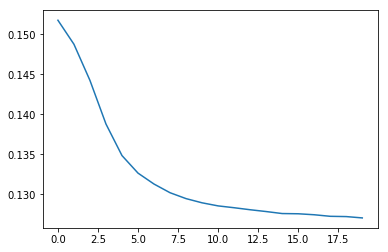

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(num_epochs), stats["train"]["loss"])

In [8]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]     # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print("Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)".format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)))

test()

Test set: Average loss: 0.126805, Accuracy: 7204/10000 (72%)
